## **Model Tuning Notebook**

In [1]:
from numba import cuda
import tensorflow as tf

def clear_gpu_memory():
    device = cuda.get_current_device()
    device.reset() # dump the memory contents to free up the memory (it accumulates over the session)
    
# CUDA (Nvidia GPU Computing)
if len(tf.config.list_physical_devices('GPU')) > 0:
    gpus = tf.config.list_physical_devices('GPU')
    print("Num GPUs Available: ", len(gpus))
    
    clear_gpu_memory()
    
    tf.config.experimental.set_memory_growth(gpus[0], True)

    tf.config.set_logical_device_configuration(
    gpus[0], 
    [tf.config.LogicalDeviceConfiguration(memory_limit=8192)])  # limit to 4GB

    tf.compat.v1.disable_eager_execution()


Num GPUs Available:  1


In [2]:
# because the utils in the src are designed to be run from the root of the project,
# and by default jupyter runs from the notebook directory we need to change the working directory to the root

import os
import sys
sys.path.append('../')

def find_project_root(filename=".git"): # .git is located in the root of the project
    current_dir = os.getcwd()
    while current_dir != os.path.dirname(current_dir): # stops only when at the root (moves up 1 level each iteration)
        if filename in os.listdir(current_dir):
            return current_dir
        current_dir = os.path.dirname(current_dir)

project_root = find_project_root()
os.chdir(project_root)  # change the working directory to the project root

print("Project root:", project_root, "CWD:", os.getcwd())

Project root: d:\deep_learning_project CWD: d:\deep_learning_project


In [3]:
%load_ext autoreload
%autoreload 2

import kerastuner as kt

from src.utils.modeling import *
from src.utils.preproc import *
from src.utils.visualizations import *

from keras.models import Model, Sequential, load_model
from keras.applications import VGG16, InceptionV3
from keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D, Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

from sklearn.metrics import classification_report

C:\Users\vic\AppData\Local\Temp\ipykernel_3248\50664938.py:4: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


### **Binary Classification Models Fine-Tuning**

#### **Hyperband Model Tuning**

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=1e-7)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
callbacks = [reduce_lr, early_stopping]

tuner = kt.Hyperband(
    keras_tuning_model_builder,
    objective='val_loss',
    max_epochs=10,
    factor=2,
    directory='hyperband_logs',
    project_name='binary_breast_cancer_cnn',
)

train_gen, val_gen, test_gen, class_weights, steps_per_epoch = preproc_pipeline(
    image_resolution=(224, 224),
    classification_type='binary',
    csv_path='image_metadata/updated_image_data.csv',
    use_data_augmentation=False,
    augmented_images_per_image=5,
    batch_size=32
)

tuner.search(train_gen, validation_data=val_gen, epochs=10, callbacks=callbacks)

In [4]:
def sequential_binary_model(
    conv_filter_1=64, 
    conv_filter_2=64, 
    conv_filter_3=128, 
    conv_filter_4=128, 
    conv_filter_5=256, 
    dense_units_0=256, 
    dropout_rate_0=0.2, 
    learning_rate=0.0001, 
    input_shape=(224, 224, 3)
):
    model = Sequential()
    model.add(Conv2D(conv_filter_1, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(conv_filter_2, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(conv_filter_3, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(conv_filter_4, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(conv_filter_5, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())
    model.add(Dense(dense_units_0, activation='relu'))
    model.add(Dropout(dropout_rate_0))

    model.add(Dense(1, activation='sigmoid'))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
train_gen, val_gen, test_gen, class_weights, steps_per_epoch = preproc_pipeline(image_resolution=(224, 224),
                                                    classification_type='binary',
                                                    use_data_augmentation=True,
                                                    augmented_images_per_image=5,
                                                    batch_size=32)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=1e-7)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
callbacks = [reduce_lr, early_stopping]

sequential_binary = sequential_binary_model()

fitted_sequential_binary = train_model(train_gen, val_gen, sequential_binary, callbacks=callbacks, class_weights=class_weights, epochs=3, steps_per_epoch=steps_per_epoch)

In [ ]:
save_model(fitted_sequential_binary, 'src/models/VGG16_binary')
save_training_history(fitted_sequential_binary, 'src/models/VGG16_binary')

In [ ]:
fitted_sequential_binary = load_model('src\models\Hyperband_binary\saved_model.h5')
evaluate_model(fitted_sequential_binary, classification_type='binary')

#### **Transfer Learning**

**VGG 16**

In [7]:
def binary_classification_vgg16_model(input_shape=(224, 224, 3), trainable_layers=10, learning_rate=0.0001):
    
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # train some layers and freeze others
    for layer in base_model.layers[:-trainable_layers]:
        layer.trainable = False
    for layer in base_model.layers[-trainable_layers:]:
        layer.trainable = True

    model = Sequential()
    
    model.add(base_model)
    
    model.add(Flatten())
    
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(1, activation='sigmoid'))
    
    # low learning rate for fine tuning
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [ ]:
train_gen, val_gen, test_gen, class_weights, steps_per_epoch = preproc_pipeline(image_resolution=(224, 224),  
                                                    classification_type='binary',
                                                    use_data_augmentation=True,
                                                    augmented_images_per_image=5,
                                                    batch_size=32)

vgg16_binary = binary_classification_vgg16_model()

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=1e-7)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
callbacks = [reduce_lr, early_stopping]
    

fitted_vgg16_binary = train_model(train_gen, val_gen, vgg16_binary, callbacks=callbacks, class_weights=class_weights, epochs=10, steps_per_epoch=steps_per_epoch)

In [17]:
save_model(fitted_vgg16_binary, 'src/models/VGG16_binary')
save_training_history(fitted_vgg16_binary, 'src/models/VGG16_binary')

Loading test data...
Loading and preprocessing data...
Total training images (no augmentation): 5533
Class weights computed.
Data generators created.
Starting model evaluation...
Total number of samples in the test generator: 1186


d:\deep_learning_project\src\utils\modeling.py:102: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  # select the appropriate class names based on the classification type
c:\Users\vic\miniconda3\envs\tf\lib\site-packages\keras\engine\training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,



Accuracy: 0.9848

Classification Report:
+-----------+-------------+----------+------------+-----------+
| Class     |   Precision |   Recall |   F1-Score |   Support |
+===========+=============+==========+============+===========+
| Benign    |    0.973262 | 0.978495 |   0.975871 |       372 |
+-----------+-------------+----------+------------+-----------+
| Malignant |    0.990148 | 0.987715 |   0.98893  |       814 |
+-----------+-------------+----------+------------+-----------+

Overall Metrics:
+------------------------+----------+
| Metric                 |    Value |
+========================+==========+
| Accuracy               | 0.984823 |
+------------------------+----------+
| Macro Avg Precision    | 0.981705 |
+------------------------+----------+
| Macro Avg Recall       | 0.983105 |
+------------------------+----------+
| Macro Avg F1-Score     | 0.982401 |
+------------------------+----------+
| Weighted Avg Precision | 0.984851 |
+------------------------+----------

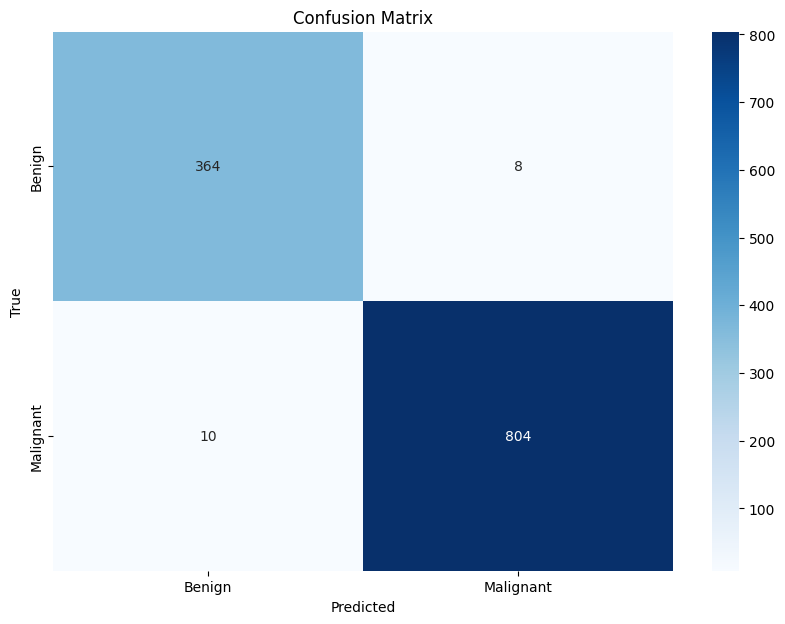

Evaluation complete. Returning results.


{'accuracy': 0.984822934232715,
 'classification_report': {'Benign': {'precision': 0.9732620320855615,
   'recall': 0.978494623655914,
   'f1-score': 0.9758713136729222,
   'support': 372.0},
  'Malignant': {'precision': 0.9901477832512315,
   'recall': 0.9877149877149877,
   'f1-score': 0.988929889298893,
   'support': 814.0},
  'accuracy': 0.984822934232715,
  'macro avg': {'precision': 0.9817049076683966,
   'recall': 0.9831048056854508,
   'f1-score': 0.9824006014859077,
   'support': 1186.0},
  'weighted avg': {'precision': 0.9848514093611562,
   'recall': 0.984822934232715,
   'f1-score': 0.9848339448361096,
   'support': 1186.0}},
 'confusion_matrix': array([[364,   8],
        [ 10, 804]], dtype=int64)}

In [20]:
fitted_vgg16_binary = load_model('src\models\VGG16_binary\saved_model.h5')
evaluate_model(fitted_vgg16_binary, classification_type='binary')

### **Multiclass Classification Models Fine-Tuning**

#### **Hyperband Model Tuning**

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=1e-7)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
callbacks = [reduce_lr, early_stopping]

tuner = kt.Hyperband(
    keras_tuning_model_builder,
    objective='val_loss',
    max_epochs=10,
    factor=2,
    directory='hyperband_logs',
    project_name='multiclass_breast_cancer_cnn',
)

train_gen, val_gen, test_gen, class_weights, steps_per_epoch = preproc_pipeline(
    image_resolution=(224, 224),
    classification_type='multiclass',
    csv_path='image_metadata/updated_image_data.csv',
    use_data_augmentation=True,
    augmented_images_per_image=5,
    batch_size=32
)
tuner.search(train_gen, validation_data=val_gen, epochs=10, callbacks=callbacks)

In [ ]:
def sequential_multiclass_model(
    conv_filter_1=64, 
    conv_filter_2=96, 
    conv_filter_3=192, 
    conv_filter_4=256, 
    conv_filter_5=256, 
    dense_units_0=128, 
    dropout_rate_0=0.2, 
    learning_rate=0.0001, 
    input_shape=(224, 224, 3)
):
    model = Sequential()
    model.add(Conv2D(conv_filter_1, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(conv_filter_2, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(conv_filter_3, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(conv_filter_4, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(conv_filter_5, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())
    model.add(Dense(dense_units_0, activation='relu'))
    model.add(Dropout(dropout_rate_0))

    model.add(Dense(1, activation='sigmoid'))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
train_gen, val_gen, test_gen, class_weights, steps_per_epoch = preproc_pipeline(image_resolution=(224, 224),
                                                    classification_type='binary',
                                                    use_data_augmentation=True,
                                                    augmented_images_per_image=5,
                                                    batch_size=32)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
callbacks = [reduce_lr, early_stopping]

sequential_multiclass = sequential_multiclass_model()

fitted_sequential_multiclass = train_model(train_gen, val_gen, sequential_multiclass, callbacks=callbacks, class_weights=class_weights, epochs=10, steps_per_epoch=steps_per_epoch)

In [ ]:
save_model(fitted_sequential_multiclass, 'src/models/VGG16_multiclass')
save_training_history(fitted_sequential_multiclass, 'src/models/VGG16_multiclass')

Loading test data...
Loading and preprocessing data...
Total training images (no augmentation): 5533
Class weights computed.
Data generators created.
Starting model evaluation...
Total number of samples in the test generator: 1186


d:\deep_learning_project\src\utils\modeling.py:106: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred_prob = model.predict_generator(test_gen, steps=(total_samples // test_gen.batch_size) + 1) # +1 to account for remaining samples that don't make a full batch



Accuracy: 0.5337

Classification Report:
+---------------------+-------------+----------+------------+-----------+
| Class               |   Precision |   Recall |   F1-Score |   Support |
+=====================+=============+==========+============+===========+
| Adenosis            |    0.626866 | 0.626866 |   0.626866 |        67 |
+---------------------+-------------+----------+------------+-----------+
| Ductal Carcinoma    |    0.824242 | 0.525097 |   0.641509 |       518 |
+---------------------+-------------+----------+------------+-----------+
| Fibroadenoma        |    0.562874 | 0.618421 |   0.589342 |       152 |
+---------------------+-------------+----------+------------+-----------+
| Lobular Carcinoma   |    0.387324 | 0.585106 |   0.466102 |        94 |
+---------------------+-------------+----------+------------+-----------+
| Mucinous Carcinoma  |    0.565789 | 0.364407 |   0.443299 |       118 |
+---------------------+-------------+----------+------------+---------

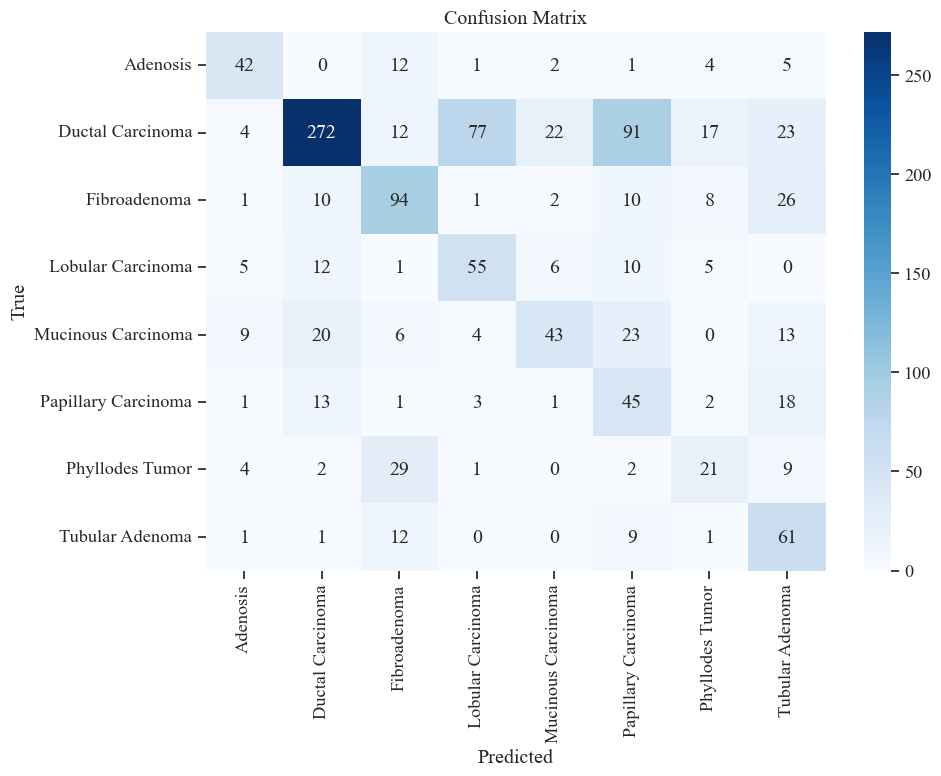

Evaluation complete. Returning results.


{'accuracy': 0.5337268128161888,
 'classification_report': {'Adenosis': {'precision': 0.6268656716417911,
   'recall': 0.6268656716417911,
   'f1-score': 0.6268656716417911,
   'support': 67.0},
  'Ductal Carcinoma': {'precision': 0.8242424242424242,
   'recall': 0.525096525096525,
   'f1-score': 0.6415094339622641,
   'support': 518.0},
  'Fibroadenoma': {'precision': 0.562874251497006,
   'recall': 0.618421052631579,
   'f1-score': 0.5893416927899686,
   'support': 152.0},
  'Lobular Carcinoma': {'precision': 0.3873239436619718,
   'recall': 0.5851063829787234,
   'f1-score': 0.4661016949152542,
   'support': 94.0},
  'Mucinous Carcinoma': {'precision': 0.5657894736842105,
   'recall': 0.3644067796610169,
   'f1-score': 0.44329896907216493,
   'support': 118.0},
  'Papillary Carcinoma': {'precision': 0.2356020942408377,
   'recall': 0.5357142857142857,
   'f1-score': 0.32727272727272727,
   'support': 84.0},
  'Phyllodes Tumor': {'precision': 0.3620689655172414,
   'recall': 0.308823

In [5]:
fitted_sequential_multiclass = load_model('src\models\Hyperband_multiclass\saved_model.h5')
evaluate_model(fitted_sequential_binary, classification_type='multiclass')

#### **Transfer Learning**

**VGG 16**

In [4]:
def multiclass_classification_vgg16_model(input_shape=(224, 224, 3), trainable_layers=10):
    
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # train some layers and freeze others
    for layer in base_model.layers[:-trainable_layers]:
        layer.trainable = False
    for layer in base_model.layers[-trainable_layers:]:
        layer.trainable = True

    model = Sequential()
    
    model.add(base_model)
    
    model.add(Flatten())
    
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(8, activation='softmax'))
    
    # low learning rate for fine tuning
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [ ]:
train_gen, val_gen, test_gen, class_weights, steps_per_epoch = preproc_pipeline(image_resolution=(224, 224), 
                                                    classification_type='multiclass',
                                                    use_data_augmentation=True,
                                                    augmented_images_per_image=5,
                                                    batch_size=32)
                                                    
vgg16_multiclass = multiclass_classification_vgg16_model()

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-7)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
callbacks = [reduce_lr, early_stopping]

fitted_vgg16_multiclass = train_model(train_gen, val_gen, vgg16_multiclass, callbacks=callbacks, class_weights=class_weights, epochs=30, steps_per_epoch=steps_per_epoch)

In [10]:
save_model(fitted_vgg16_multiclass, 'src/models/VGG16_mutlticlass')
save_training_history(fitted_vgg16_multiclass, 'src/models/VGG16_multiclass')

INFO:tensorflow:Assets written to: ram://af12a1f1-eec7-491e-9610-320a8c49c155/assets


INFO:tensorflow:Assets written to: ram://af12a1f1-eec7-491e-9610-320a8c49c155/assets


Loading test data...
Loading and preprocessing data...
Total training images (no augmentation): 5533
Class weights computed.
Data generators created.
Starting model evaluation...
Total number of samples in the test generator: 1186


d:\deep_learning_project\src\utils\modeling.py:106: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred_prob = model.predict_generator(test_gen, steps=(total_samples // test_gen.batch_size) + 1) # +1 to account for remaining samples that don't make a full batch
c:\Users\vic\miniconda3\envs\tf\lib\site-packages\keras\engine\training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,



Accuracy: 0.8879

Classification Report:
+---------------------+-------------+----------+------------+-----------+
| Class               |   Precision |   Recall |   F1-Score |   Support |
+=====================+=============+==========+============+===========+
| Adenosis            |    0.984375 | 0.940299 |   0.961832 |        67 |
+---------------------+-------------+----------+------------+-----------+
| Ductal Carcinoma    |    0.948665 | 0.891892 |   0.919403 |       518 |
+---------------------+-------------+----------+------------+-----------+
| Fibroadenoma        |    0.904762 | 0.875    |   0.889632 |       152 |
+---------------------+-------------+----------+------------+-----------+
| Lobular Carcinoma   |    0.674797 | 0.882979 |   0.764977 |        94 |
+---------------------+-------------+----------+------------+-----------+
| Mucinous Carcinoma  |    0.916667 | 0.838983 |   0.876106 |       118 |
+---------------------+-------------+----------+------------+---------

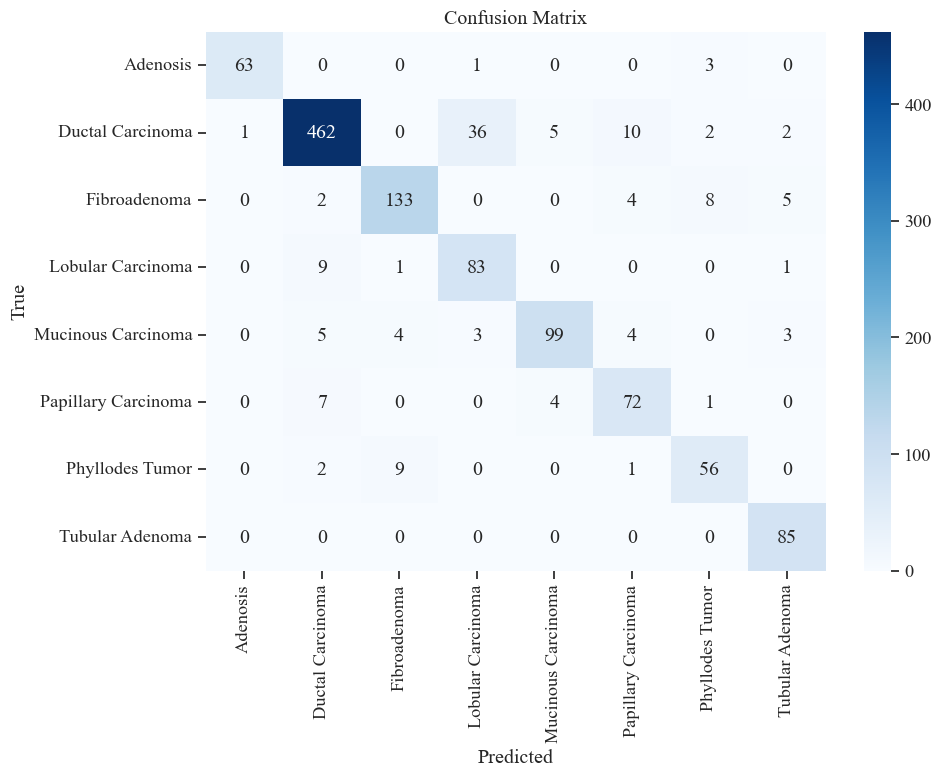

Evaluation complete. Returning results.


{'accuracy': 0.887858347386172,
 'classification_report': {'Adenosis': {'precision': 0.984375,
   'recall': 0.9402985074626866,
   'f1-score': 0.9618320610687023,
   'support': 67.0},
  'Ductal Carcinoma': {'precision': 0.9486652977412731,
   'recall': 0.8918918918918919,
   'f1-score': 0.9194029850746268,
   'support': 518.0},
  'Fibroadenoma': {'precision': 0.9047619047619048,
   'recall': 0.875,
   'f1-score': 0.8896321070234113,
   'support': 152.0},
  'Lobular Carcinoma': {'precision': 0.6747967479674797,
   'recall': 0.8829787234042553,
   'f1-score': 0.7649769585253456,
   'support': 94.0},
  'Mucinous Carcinoma': {'precision': 0.9166666666666666,
   'recall': 0.8389830508474576,
   'f1-score': 0.8761061946902655,
   'support': 118.0},
  'Papillary Carcinoma': {'precision': 0.7912087912087912,
   'recall': 0.8571428571428571,
   'f1-score': 0.8228571428571428,
   'support': 84.0},
  'Phyllodes Tumor': {'precision': 0.8,
   'recall': 0.8235294117647058,
   'f1-score': 0.811594202

In [6]:
fitted_vgg16_multiclass = load_model('src\models\VGG16_multiclass\saved_model.h5')
evaluate_model(fitted_vgg16_multiclass, classification_type='multiclass')

In [ ]:
history_vgg16_binary = {
    'loss': [0.3881, 0.2038, 0.1453, 0.1184, 0.1027, 0.0956, 0.0695, 0.0616, 0.0608, 0.0553, 0.0583, 0.0609, 0.0553, 0.0413, 0.0394],
    'accuracy': [0.8250, 0.9180, 0.9421, 0.9529, 0.9617, 0.9628, 0.9740, 0.9770, 0.9767, 0.9795, 0.9777, 0.9783, 0.9807, 0.9846, 0.9856],
    'val_loss': [0.2230, 0.1898, 0.1615, 0.1241, 0.2154, 0.2113, 0.0979, 0.1304, 0.1548, 0.1999, 0.2550, 0.1098, 0.2333, 0.1204, 0.1753],
    'val_accuracy': [0.9106, 0.9191, 0.9309, 0.9519, 0.9250, 0.9148, 0.9680, 0.9562, 0.9637, 0.9410, 0.9317, 0.9604, 0.9191, 0.9722, 0.9528],
}

In [ ]:
p plt.figure(figsize=(25, 8))
for i, metric in enumerate(['loss', 'accuracy']):
    plt.subplot(1, 2, i + 1)
    plot_results(history_vgg16_multiclass, metric, label='VGG16 Multiclass')
plt.show()

In [ ]:
plt.figure(figsize=(20, 8))

models = [
    ('VGG16 Binary', history_sequential_multiclass),
    ('VGG16 Multiclass', history_vgg16_multiclass)
]

for i, (label, history) in enumerate(models):
    for j, metric in enumerate(['loss', 'accuracy']):
        plt.subplot(1, 2, j + 1)
        plot_results(history, metric, label)

plt.tight_layout()
plt.show()